# PSO Clustering code

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [2]:
class Particle:
  def __init__(self, n_centroids, dataset, dim=2, w=0.3, a1=1.5, a2=1.5):
    self.n_centroids = n_centroids # number of clusters
    self.centroids = np.array(random.choices(dataset, k=self.n_centroids)) # assign centroids to samples randomly
    self.velocities = np.zeros((self.n_centroids, dim))
    self.best_centroid = np.zeros((self.n_centroids, dim)) # stores the best positions of each centroid
    self.r1 = np.random.uniform(low=0, high=1, size=(self.n_centroids,dim)) # random vector 1
    self.r2 = np.random.uniform(low=0, high=1, size=(self.n_centroids,dim)) # random vector 2
    self.dim = dim
    self.fitness = 99999
    self.prev_fitness = 99999
    self.inertia = w
    self.a1 = a1
    self.a2 = a2
    self.best_cluster = 0
    self.fitness_hist = []
    self.reset_datapoints() # stores all the data points that belong to each cluster

  def reset_datapoints(self):
    self.datapoints = []
    for i in range(self.n_centroids):
      self.datapoints.append([])

  def _fitness(self):
    self.prev_fitness = self.fitness
    error = 0
    for j in range(self.n_centroids):
      Cij = self.datapoints[j] # Cij is each cluster, containing all the datapoints
      for Z_p in Cij: # for each data point belonging to cluster Cij
        dist = math.dist(Z_p, self.centroids[j]) # distance from each datapoint to cluster j
        dist /= len(Cij) # divided by the number of data points belonging to the cluster
        error += dist 
    error /= self.n_centroids

    self.fitness = error
    self.fitness_hist.append(self.fitness)
    return self.fitness
  
  def create_random_vectors(self):
    self.r1 = np.random.uniform(low=0, high=1, size=(self.n_centroids,self.dim))
    self.r2 = np.random.uniform(low=0, high=1, size=(self.n_centroids,self.dim))
  
  def update_vel(self, global_best):
    for i, vel in enumerate(self.velocities):
      curr_vel_w = self.inertia * vel
      personal_influence = self.a1 * (np.multiply(self.r1[i], np.subtract(self.best_centroid[i], self.centroids[i])))
      social_influence = self.a2 * (np.multiply(self.r2[i], np.subtract(global_best[i], self.centroids[i])))

      self.velocities[i] = curr_vel_w + personal_influence + social_influence

  def update_pos(self):
    for i, vel in enumerate(self.velocities):
      self.centroids[i] += vel

    self.create_random_vectors()


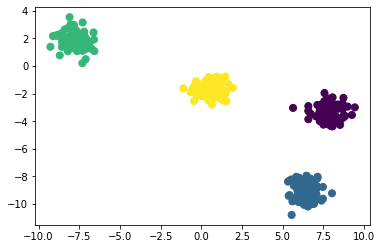

In [3]:
n_particles = 10
n_centroids = 4
particles = []

Z, y_true = make_blobs(n_samples=300, centers=n_centroids,
                       cluster_std=0.60, random_state=6)
plt.scatter(Z[:, 0], Z[:, 1], s=50, c=y_true)

In [4]:
for i in range(n_particles):
  particles.append(Particle(n_centroids, w=0.2, dataset=Z))

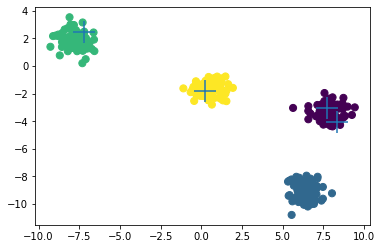

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(Z[:, 0], Z[:, 1], s=50, c=y_true, marker='o')
ax1.scatter(particles[0].centroids[:, 0], particles[0].centroids[:, 1], s=500,marker='+')

plt.show()

In [6]:
def PSO(Z, n_centroids, particles):
    for o in range(30):
        global_best = np.zeros((n_centroids, 2))
        fit_best = 99999
        particle_best = 0

        for i in tqdm(range(100)):
            for index, i in enumerate(particles):
                i.reset_datapoints()
                
                for idx, z_p in enumerate(Z): # distance between zp and each centroid
                    dist = []
                    for m in i.centroids:
                        dist.append(math.dist(z_p, m))

                        minIdx = np.argmin(dist) # pick closer cluster
                        i.datapoints[minIdx].append(z_p) # assign data point to that cluster
                
                cur_fit = i._fitness() # calculate fitness
                if cur_fit < i.prev_fitness:
                    i.best_centroid = i.centroids # update best fitness
                    
                for index, i in enumerate(particles):
                    if i.fitness < fit_best:
                        fit_best = i.fitness
                        particle_best = index
                    particles[particle_best].best_cluster = particle_best
                    global_best = particles[particle_best].best_centroid

                for index, i in enumerate(particles):
                    i.update_vel(global_best)
                    i.update_pos()
    return particles, particle_best

In [7]:
particles, particle_best = PSO(Z, n_centroids, particles)

100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


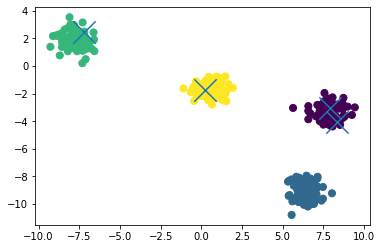

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(Z[:, 0], Z[:, 1], s=50, c=y_true, marker='o')
ax1.scatter(particles[particle_best].centroids[:, 0], particles[particle_best].centroids[:, 1], s=500,marker='x')

plt.show()

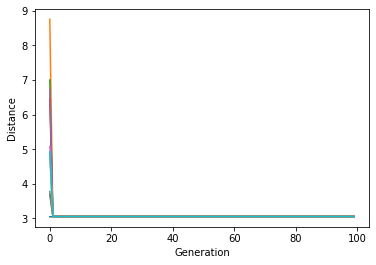

In [9]:
for p in particles:
    plt.plot(p.fitness_hist)
    plt.ylabel('Distance')
    plt.xlabel('Generation')

plt.show()

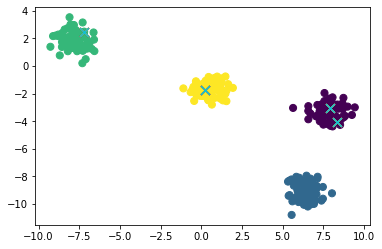

In [10]:
plt.scatter(Z[:, 0], Z[:, 1], s=50, c=y_true, marker='o')
for p in particles:
    plt.scatter(p.best_centroid[:, 0], p.best_centroid[:, 1], s=75,marker='x')

plt.show()

In [11]:
def kmean_func(X, Y, n_clusters):
    final_h = []
    for i in range(30):
        kmeans = KMeans(
            init="random",
            n_clusters=n_centroids,
            n_init=10,
            max_iter=100,
            random_state=42
        )

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(X)
        kmeans.fit(scaled_features)
        label_encoder = preprocessing.LabelEncoder()
        true_labels = label_encoder.fit_transform(Y)
        kmeans.fit(scaled_features)
        label_encoder = preprocessing.LabelEncoder()

        centroids = kmeans.cluster_centers_

        clusters = []
        for i in range(n_centroids):
            clusters.append([])
        for idx, z_p in enumerate(X):
            clusters[kmeans.labels_[idx]].append(z_p)

        error = 0
        for j in range(n_clusters):
            Cij = clusters[j] # Cij is each cluster, containing all the datapoints
            for Z_p in Cij: # for each data point belonging to cluster Cij
                dist = math.dist(Z_p, centroids[j]) # distance from each datapoint to cluster j
                dist /= len(Cij) # divided by the number of data points belonging to the cluster
                error += dist 
            error /= 4
        final_h.append(error)
    plt.plot(final_h)

    return kmeans


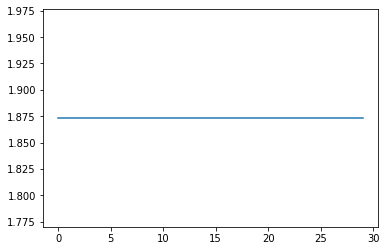

In [12]:
kmeans = kmean_func(Z, y_true, n_centroids)

# Iris dataset

KMeans(init='random', max_iter=100, n_clusters=4, random_state=42)

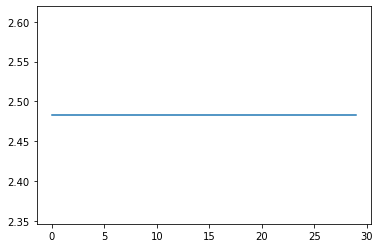

In [13]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
kmean_func(X, y, 3)

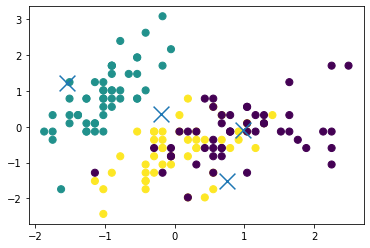

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

plt.scatter(scaled_features[:, 0], scaled_features[:, 1], s=50, c=y, marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250,marker='x')
plt.show()

<ipython-input-15-2950fdecffbe>:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)


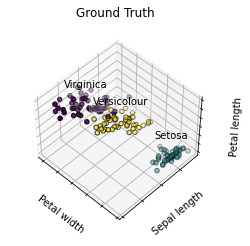

In [15]:
# Plot the ground truth
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")
ax.dist = 12

fig.show()

In [16]:
particles = []
for i in range(n_particles):
  particles.append(Particle(4, w=0.2, dim=4, dataset=X))
particles, particle_best = PSO(X, 4, particles)

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


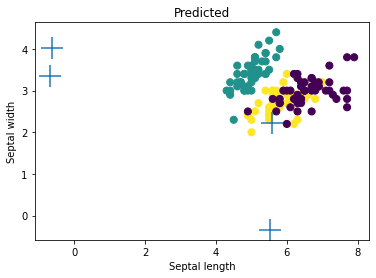

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X[:, 0], X[:, 1], s=50, c=y, marker='o')
ax1.scatter(particles[0].centroids[:, 0], particles[0].centroids[:, 1], s=500,marker='+')
ax1.set_ylabel('Septal width')
ax1.set_xlabel('Septal length')
ax1.set_title('Predicted')
plt.show()

In [ ]:
y_true

array([1, 0, 0, 2, 1, 2, 1, 3, 2, 0, 1, 1, 2, 2, 3, 0, 3, 2, 2, 0, 3, 1,
       3, 3, 1, 2, 2, 0, 1, 1, 2, 1, 2, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 2,
       1, 2, 2, 2, 3, 1, 3, 3, 3, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 0,
       1, 3, 3, 1, 0, 0, 0, 0, 1, 3, 0, 2, 2, 1, 0, 3, 1, 3, 3, 1, 2, 0,
       0, 3, 1, 3, 3, 2, 3, 0, 3, 0, 0, 2, 2, 3, 1, 0, 3, 1, 2, 3, 2, 3,
       2, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 3, 0, 3, 3, 0, 1, 0, 1, 1, 1,
       0, 3, 3, 1, 3, 0, 2, 3, 0, 0, 0, 1, 1, 2, 1, 0, 1, 3, 2, 1, 1, 1,
       0, 3, 3, 1, 3, 0, 3, 2, 1, 3, 3, 3, 0, 2, 3, 1, 3, 2, 1, 0, 0, 3,
       1, 2, 0, 0, 2, 0, 3, 0, 1, 3, 1, 0, 3, 2, 2, 1, 3, 1, 3, 2, 3, 2,
       2, 2, 2, 3, 2, 1, 0, 0, 2, 2, 1, 3, 3, 1, 0, 1, 0, 3, 3, 3, 0, 1,
       2, 1, 3, 0, 2, 2, 0, 2, 2, 0, 1, 2, 3, 1, 0, 3, 1, 2, 3, 2, 3, 3,
       2, 1, 0, 1, 3, 1, 3, 1, 0, 3, 3, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2,
       0, 2, 0, 3, 2, 0, 0, 1, 3, 0, 3, 2, 3, 0, 3, 0, 1, 0, 1, 0, 2, 0,
       1, 2, 3, 3, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2])

In [18]:
y_pred = []
for p in particles:
    y_pred.append(p.best_cluster)

ValueError: Length of values (300) does not match length of index (150)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1d441027-efce-42e4-8145-3566f79590a0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>